# Introduction

## Goal.
The goal of this lab is to study the application of quality-diversity algorithms, in particular the Multi-dimensional Archive of Phenotypic Elites (MAP-Elites) to various kinds of problems. We will also investigate the parametrization of the algorithm and its effect on the algorithmic performance.

## Getting started. 
In this lab we will use the `qdpy`$^{[1]}$ library, as well as the `deap` library seen in the previous lab. All the exercises are based on the examples available in the library$^{[2]}$, with some modifications. Please note that the `qdpy` library contains many other quality-diversity algorithms, such as Novelty Search, and advanced variants of MAP-Elites. However, in this lab we will use for simplicity only the vanilla version of MAP-Elites.

The basic version of MAP-Elites is shown in Algorithm 1. In the pseudo-code, $\textbf{x}$ and $\textbf{x}'$ are candidate solutions (i.e., $n$-dimensional vectors defined in the search space $\textbf{D}$); $\textbf{b}'$ is a *feature descriptor*, that is a location in a user-defined *discretized* feature space (which can be seen as a *grid* made of *bins*), corresponding to the candidate solution $\textbf{x}'$, (i.e., an $N$-dimensional vector of user-defined features that characterize $\textbf{x}'$, typically with $N<n$); $p'$ is the performance of the candidate solution $\textbf{x}'$ (i.e., the scalar value returned by the objective function $f(\textbf{x}')$ ; $\mathcal{P}$ is a $<$ feature descriptor, performance $>$ map (i.e., an associative table that stores the best performance associated to each feature descriptor encountered by the algorithm); $\mathcal{X}$ is a $<$ feature descriptor, solution $>$ map (i.e., an associative table that stores the best solution associated to each feature descriptor encountered by the algorithm); $ \mathcal{P}(\textbf{b}') $ is the best performance associated to the feature descriptor $ \textbf{b}' $ (it can be empty); $\mathcal{X}(\textbf{b}') $ is the best solution associated to the feature descriptor $\textbf{b}' $ (it can be empty).

![alg1.png](img/img_12/alg1.png)

Following the pseudo-code shown above, the algorithm first creates the two maps $\mathcal{P}$ and $\mathcal{X}$, which are initially empty. Then, a while loop is executed until a given stop criterion is not met (usually, on the maximum number of function evaluations). Each iteration of the loop evaluates a *batch* of solutions. In the first batch, a given number of solutions are randomly sampled, see the `randomSolution()` function, in the search space $\textbf{D}$, which are used for initializing the two maps $\mathcal{P}$ and $\mathcal{X}$. Then, starting from the next iteration, solutions are first randomly selected from the current map $\mathcal{X}$, through the randomSelection() operator, and then perturbed according to the `randomVariation()` operator. For each new solution $\textbf{x}'$, the corresponding feature descriptor $\textbf{b}'$ and performance $p'$ are then evaluated. At this point, the two maps $\mathcal{P}$ and $\mathcal{X}$ are updated: if the performance associated to $\textbf{b}'$, $\mathcal{P}(\textbf{b}')$, is empty (which can happen if this is the first time that the algorithm generates a solution with that feature descriptor), or if it contains a value that is worse than the performance $p'$ of the newly generated solution (in the pseudo-code, we assume a minimization problem, therefore we check the condition $\mathcal{P}(\textbf{b}') > p'$), the new solution $\textbf{x}'$ and its performance $p'$ are assigned to the elements of the maps corresponding to its feature descriptor $\textbf{b}'$, namely $\mathcal{P}(\textbf{b}')$ and $\mathcal{X}(\textbf{b}')$. Once the loop terminates, the algorithm returns the two maps $\mathcal{P}$ and $\mathcal{X}$, which can be later analyzed for further inspection and post-processing.

It can be immediately noted how simple the algorithm is. With reference to the pseudo-code, in order to apply MAP-Elites to a specific problem the following methods must be defined:

 - $\textrm{randomSolution()}$: returns a randomly generated solution;
 - $\textrm{randomSelection($\mathcal{X}$)}$: randomly selects a solution from $\mathcal{X}$;
 - $\textrm{randomVariation($\textbf{x}$)}$: returns a modified copy of $\textbf{x}$;
 - $\textrm{featureDescriptor}(\textbf{x})$: maps a candidate solution $\textbf{x}$ to its feature descriptor, $\textbf{b}$;
 - $\textrm{performance}(\textbf{x})$: evaluates the objective function of the candidate solution $\textbf{x}$.

The first three methods are rather standard, i.e., they can be based on general-purpose operators typically used in EAs. However, it is possible to customize them according to the specific need. For instance, in the first two exercises of this lab we will use uniform random sampling and uniform random selection for the first two operators. For the variation operator, we will use the `RandomSearchMutPolyBounded` operator provided by `qdpy`, which essentially performs uniform random mutations with a saturation on the bounds of the search space. In the third exercise, we will use instead the typical operators of Genetic Programming.

As for what concerns $\textrm{featureDescriptor}(\textbf{x})$ and $\textrm{performance}(\textbf{x})$, these are obviously problem-dependent: the first one, being dependent on how the user defines the features of interest and the corresponding feature space; the latter, being dependent on the specific objective function at hand. In the exercises, we will see different definitions of performances and descriptors.

---
[1]: A Quality-Diversity framework for Python 3.6+: https://gitlab.com/leo.cazenille/qdpy

[2]: Examples avaiable at https://gitlab.com/leo.cazenille/qdpy/-/tree/master/examples

# Exercise 1
In this exercise, we will use MAP-Elites to _illuminate_ the feature space of a benchmark function that we have already used in some of the first labs, namely the Rastrigin function $^{[1]}$, which as you may remember is a highly multimodal problem.

For simplicity, we will use as feature descriptor for MAP-Elites the first two variables of the problem. Note however that, in general, the features used in MAP-Elites can be any property (different from the fitness function) of the solutions to the problem at hand.

To start the experiments, run the next cell. This will allow you to reproduce your results. At the end of the run, the script will generate a series of plots (see the figure below) in the `results/ex1/seed` directory, namely: 

 - `activityGrid.pdf`: this map indicates, for each bin, how many times that bin has been updated (i.e., its elite has been replaced) during the evolutionary process;
 - `evals_contsize.pdf`: this trend indicates the cumulative number of bins filled during the evolutionary process; 
 - `evals_fitnessmax0.pdf`: this trend is the usual fitness trend that we have seen in the previous labs (note: in this case the fitness has to be minimized);
 - `iterations_nbupdated.pdf`: this trend indicates how many bins are updated at each iteration of MAP-Elites;
 - `performancesGrid.pdf`: this is the final _illumination_ map that shows how the performance of the elites changes depending on the features at hand (brighter color indicates better results-note that the fitness is normalized in [0,1]).

The main outputs of the experiments of the first exercise are an *activity grid* (see the figure below, left), and a *performance grid* (see the figure below, right). More plots are available in the exercise folder after the execution of the experiments.

![ex1.png](img/img_12/ex1.png)

Furthermore, the script will serialize the final version of the map handled by MAP-Elites in a pickle file named `final.p`, that can be deserialized and manipulated for further analysis.

 - What kind of considerations can you make regarding the fitness trend (Is the algorithm able to converge to a reasonably low fitness function? How quick is the convergence?), and the activity grid (For instance, are there regions of the feature space that are visited/updated more frequently than others?). What kind of illumination pattern do you observe? Do you see any trend/correlation between performance and features of the map?


 1. Fitness Trend (evals_fitnessmax0.pdf):
The fitness trend shows that the algorithm is able to converge quickly to a reasonably low fitness value. Most of the improvement happens within the first 2000 evaluations.
After this rapid initial convergence, the fitness value stabilizes and only improves slightly for the remaining evaluations.
The fact that the fitness decreases significantly early on indicates that the algorithm is efficiently exploring the solution space and finding better solutions quickly.
2. Container Size (evals_contsize.pdf):
The container size increases steadily and approaches the maximum number of bins (approximately 1000) before reaching the budget limit of 10,000 evaluations.
This suggests that the algorithm is populating the feature space effectively and exploring a wide range of solutions.
3. Number of Updated Bins (iterations_nbupdated.pdf):
The number of bins updated per iteration decreases over time. Initially, many bins are updated, but as the search progresses, fewer updates occur.
This indicates that the search is initially exploratory, filling many regions of the map. As good solutions are found, the updates slow down because the algorithm is focusing on refining existing solutions.
4. Activity Grid (activityGrid.pdf):
The activity grid shows that some regions of the feature space are visited and updated more frequently than others. This could indicate that these regions are more promising in terms of producing good fitness values or are more densely populated with potential solutions.
There are also regions with little to no updates, suggesting that these areas may be less favorable or harder to explore.
5. Illumination Pattern (performancesGrid.pdf):
The illumination map shows a diverse range of performances across the feature space. Some regions exhibit high performance (brighter colors), while others show lower performance.
There is a visible correlation between features and performance, as some areas consistently yield better solutions.
The map suggests that the algorithm successfully illuminates a variety of solutions with different characteristics, providing a broad set of elites to choose from.
    
 - Try to change the parameters of the MAP-Elites algorithm, i.e.,: `NO_BINS`, `MAX_ITEMS_BIN`, `BUDGET`, `BATCH_SIZE`, which indicate, respectively, the number of bins (that is the same for both features), the maximum number of items stored in each bin of the grid, the total budget of the evolutionary process (number of function evaluations), and the batch size, i.e., how many solutions are evaluated at each iteration of MAP-Elites. Focus in particular on `NO_BINS`. What is the effect on the fitness trend and the performance map when you increase or decrease the number of bins?

 Modifica di NO_BINS

Aumento dei bin: Aumentando il numero di bin (NO_BINS), la mappa diventa più dettagliata, ma riempire tutti i bin diventa più difficile. Questo può portare a una copertura parziale dello spazio delle feature e a una diminuzione della qualità media delle soluzioni.
Diminuzione dei bin: Riducendo il numero di bin, la granularità diminuisce e la copertura della mappa diventa più semplice. Tuttavia, si perde in dettaglio e diversità delle soluzioni.
Modifica di MAX_ITEMS_BIN

Aumento del numero massimo di soluzioni per bin: Permette di conservare più soluzioni in ciascun bin, favorendo la diversità. Tuttavia, può rallentare l’algoritmo a causa della maggiore quantità di dati da gestire.
Valore basso: Riduce la diversità ma semplifica l’ottimizzazione.
Modifica di BUDGET e BATCH_SIZE

Aumento del budget: Consente all'algoritmo di esplorare più soluzioni, migliorando la copertura e la qualità delle soluzioni finali.
Batch più grande: Accelera la valutazione delle soluzioni ma può saturare rapidamente la mappa.
    
 - Try to change the problem dimension (`PROBLEM_DIM`) to a much larger value, for instance 10 (remember that Rastrigin is a scalable benchmark problem, meaning that it can be defined for any number of variables). Note that in any case the first two variables are taken as features for MAP-Elites. What kind of considerations can you make in this case regarding the illumination pattern and the other aspects (i.e., the fitness trend and the activity grid) of the results? Does illumination become more difficult (i.e., less bins are visited, with poorer performance)? Why?

---

[1]: Rastrigin function https://pythonhosted.org/inspyred/reference.html\#inspyred.benchmarks.Rastrigin

run1 {'NO_BINS': 32, 'MAX_ITEMS_BIN': 1, 'BUDGET': 10000, 'BATCH_SIZE': 500, 'PROBLEM_DIM': 3}
Seed: 288779
alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed
RandomSearchMutPolyBounded-2080230987920     0         400/1024  500       448            [0.3924]  [0.1293]  [0.0464]  [0.7601]  [0.0024,0.0037]     [0.9983,0.9981]     243.03    1.02   
RandomSearchMutPolyBounded-2080230987920     1         578/1024  500       263            [0.3775]  [0.1313]  [0.0464]  [0.7601]  [0.0024,0.0018]     [0.9969,0.9981]     359.79    1.07   
RandomSearchMutPolyBounded-2080230987920     2         710/1024  500       237            [0.3681]  [0.1283]  [0.0464]  [0.7425]  [0.0003,0.0018]     [0.9969,0.9981]     448.65    1.10   
RandomSearchMutPolyBounded-2080230987920     3         798/1024  500       210            [0.3607]  [0.1268]  [0.0464]  [0.8262]  [0.0003,0.0018

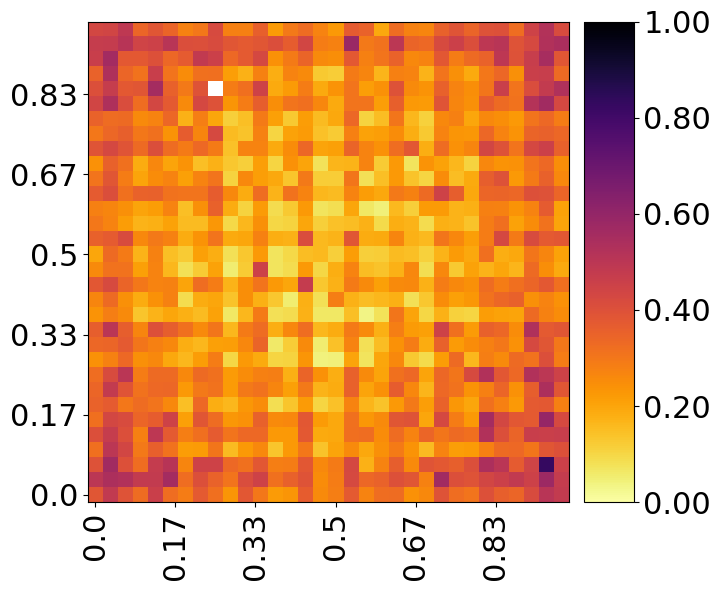

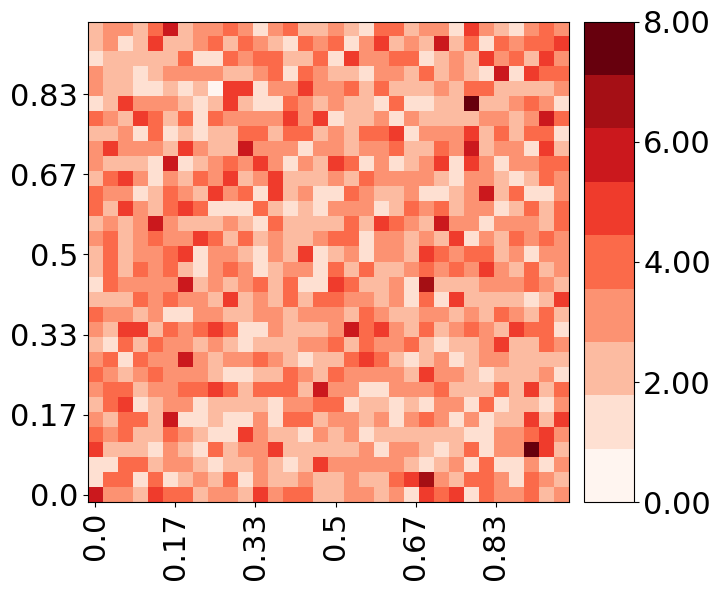

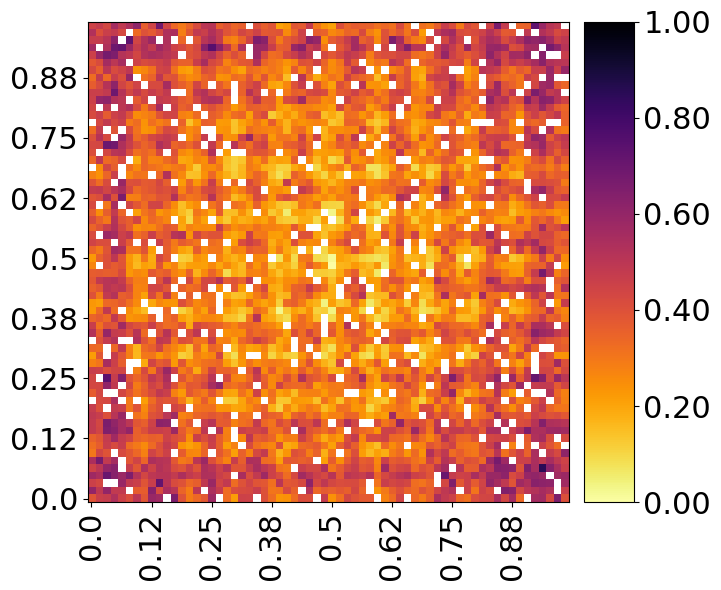

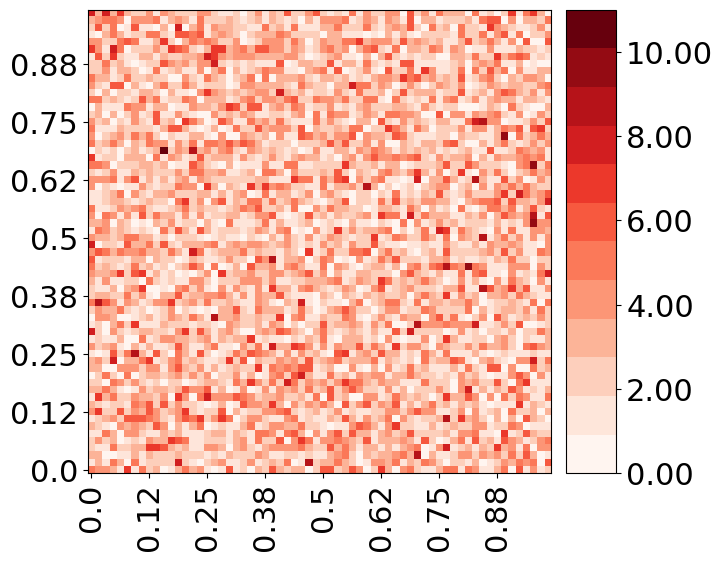

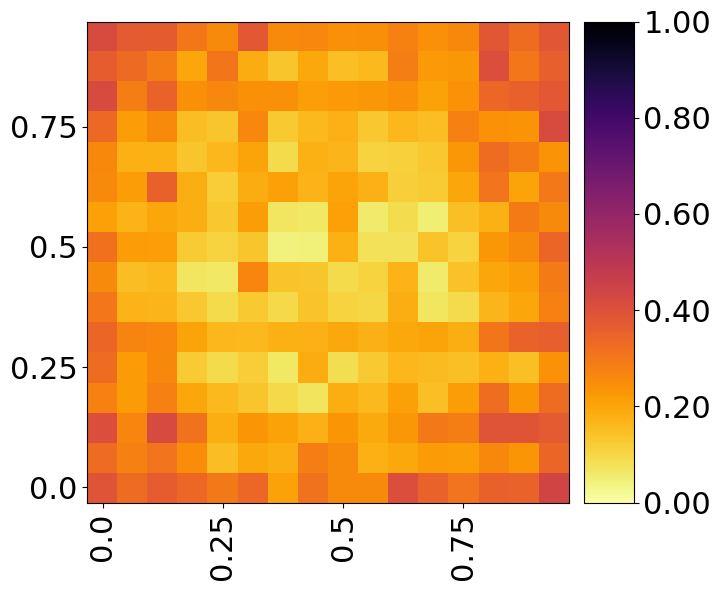

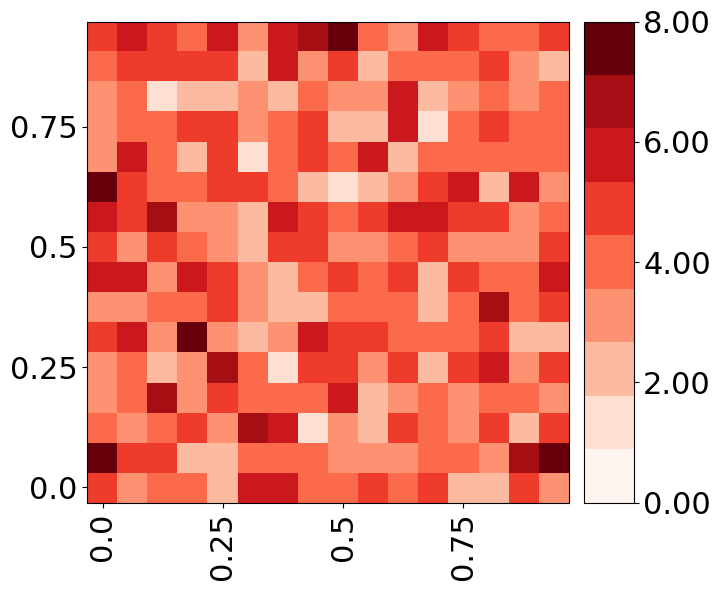

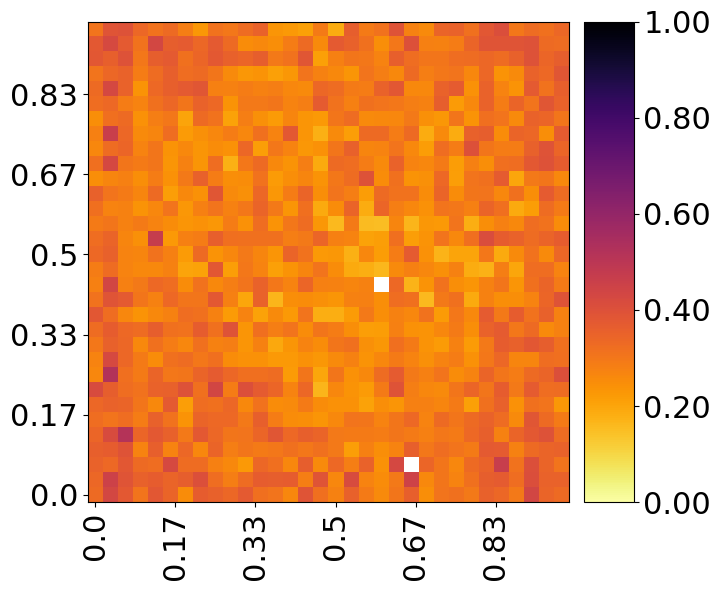

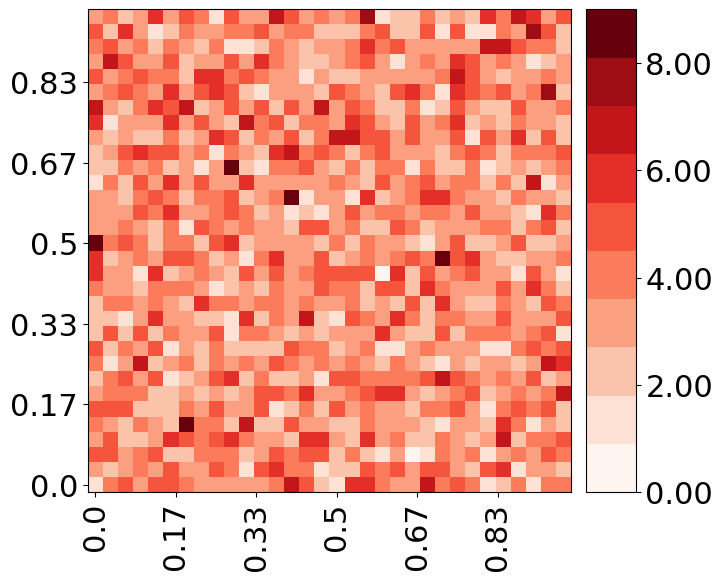

In [2]:
from utils.utils_12.exercise_rastrigin import main

"""
-------------------------------------------------------------------------
Edit this part to do the exercises
"""

# TODO: change these parameters
NO_BINS=32          # default 32 Numero di bin (celle) lungo ciascuna dimensione del feature space.
MAX_ITEMS_BIN=1     # default 1 Numero massimo di soluzioni che possono essere memorizzate in ciascun bin.
BUDGET=10000        # default 10000 Numero massimo di valutazioni della funzione obiettivo.
BATCH_SIZE=500      # default 500 Numero di soluzioni valutate ad ogni iterazione.
PROBLEM_DIM=3       # default 3 Numero di dimensioni del problema (funzione di Rastrigin).

runs = {
    'run1': {'NO_BINS': 32, 'MAX_ITEMS_BIN': 1, 'BUDGET': 10000, 'BATCH_SIZE': 500, 'PROBLEM_DIM': 3},
    'run2': {'NO_BINS': 64, 'MAX_ITEMS_BIN': 5, 'BUDGET': 15000, 'BATCH_SIZE': 500, 'PROBLEM_DIM': 3},
    'run3': {'NO_BINS': 16, 'MAX_ITEMS_BIN': 1, 'BUDGET': 5000, 'BATCH_SIZE': 250, 'PROBLEM_DIM': 3},
    'run4': {'NO_BINS': 32, 'MAX_ITEMS_BIN': 1, 'BUDGET': 10000, 'BATCH_SIZE': 500, 'PROBLEM_DIM': 10},

    }

"""
-------------------------------------------------------------------------
"""

for run in runs:
    print(run, runs[run])
    NO_BINS = runs[run]['NO_BINS']
    MAX_ITEMS_BIN = runs[run]['MAX_ITEMS_BIN']
    BUDGET = runs[run]['BUDGET']
    BATCH_SIZE = runs[run]['BATCH_SIZE']
    PROBLEM_DIM = runs[run]['PROBLEM_DIM']
    main(NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [6]:
import pickle


for run in ['run1', 'run2', 'run3', 'run4']:
    print('-------------------------------------')
    print(f'risultati della {run}')
    with open(f"results/ex1/{run}/final.p", "rb") as f:
        data = pickle.load(f)

    grid = data['container']
    print('best individual:\t',grid.best)           # Migliore individuo
    print('best fitness:\t',grid.best.fitness)   # Fitness del miglior individuo
    print('best features:\t',grid.best.features)  # Feature descriptor del miglior individuo



-------------------------------------
risultati della run1
best individual:	 Individual([0.588065373790736, 0.40561622531669894, 0.403430351140869])
best fitness:	 (0.0347274258250579,)
best features:	 [0.588065373790736, 0.40561622531669894]
-------------------------------------
risultati della run2
best individual:	 Individual([0.5036355483044328, 0.49688755185861, 0.5011555640180663])
best fitness:	 (0.0036232077980710656,)
best features:	 [0.5036355483044328, 0.49688755185861]
-------------------------------------
risultati della run3
best individual:	 Individual([0.39952683867257266, 0.5055796200836082, 0.3066150413676656])
best fitness:	 (0.0422761606538458,)
best features:	 [0.39952683867257266, 0.5055796200836082]
-------------------------------------
risultati della run4
best individual:	 Individual([0.5967653002902774, 0.5879023173849983, 0.8719543683077835, 0.7155738804116557, 0.49792453098001654, 0.6686216486155679, 0.5939281555468231, 0.3266576636832278, 0.3114640930802015

# Exercise 2
This exercise is similar to the previous one. The main difference is that in this case the objective function and feature descriptor are defined by a custom function, see `eval_fn`, that returns for each individual its fitness (`score`) and two features (`fit0` and `fit1`). Note that the fitness and features are based on trigonometric functions and are defined as scalable, i.e., they can be evaluated for any number of variables. 

To start the experiments, run the next cell. At the end of the run, the script will generate the same plots discussed in the previous exercise, as well as the pickle file containing the raw results, but it will save the results in the `results/ex2/seed` folder.


 - What kind of considerations can you make in this case regarding the fitness trend and illumination pattern?

Fitness Trend
Convergence:

The fitness trend (third image) shows a clear decrease, indicating that the algorithm is capable of minimizing the fitness function effectively.
The convergence is relatively quick during the early evaluations, with significant reductions in fitness occurring within the first few thousand evaluations.
After this initial phase, the improvement rate slows down, but there are still incremental reductions in fitness.


Plateau:
The fitness reaches a plateau towards the end of the budget limit, suggesting that the algorithm might have explored the available space efficiently within the given budget.


Illumination Pattern

Distribution of Updates:
The activity grid (first image) shows that certain regions of the feature space are visited and updated more frequently than others.
The updates are concentrated along a curved region, suggesting that these areas are more likely to contain better-performing individuals.


Performance Map:
The illumination map (fifth image) reveals a distinct pattern where higher performance (brighter areas) is concentrated along the curved regions, while other parts of the feature space have lower performance.
This pattern suggests that the custom objective function results in a non-uniform distribution of high-performing individuals, concentrated along specific feature combinations.


Correlation Between Features and Performance:
There appears to be a correlation between certain feature regions and better fitness scores. The concentration of high-performing elites along a curved line indicates a potential relationship between the trigonometric features (fit0 and fit1) and optimal solutions.
This structure might be a result of the trigonometric nature of the evaluation function, which creates specific patterns in the feature space.

 
 -  Also in this case, try to change `NO_BINS` and `PROBLEM_DIM`, and see if you can confirm the observations made in the previous experiment.
 
 - If you want, you could try to change the custom function definition in `eval_fn` and replicate the experiment with a different setting. What kind of results do you obtain?

run1 {'NO_BINS': 32, 'MAX_ITEMS_BIN': 1, 'BUDGET': 10000, 'BATCH_SIZE': 500, 'PROBLEM_DIM': 3, 'EVAL_FN': <function eval_fn at 0x000001E457766700>}
Seed: 476907
alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed
RandomSearchMutPolyBounded-2080158528208     0         31/1024   500       33             [1.3276]  [0.3504]  [0.1808]  [1.8364]  [0.0176,0.0608]     [0.9932,0.9344]     8.95      0.89   
RandomSearchMutPolyBounded-2080158528208     1         105/1024  500       90             [1.2641]  [0.4294]  [0.0618]  [1.8364]  [0.0055,0.0283]     [0.9935,0.9737]     31.38     1.13   
RandomSearchMutPolyBounded-2080158528208     2         172/1024  500       100            [1.2447]  [0.4337]  [0.0584]  [1.8364]  [0.0049,0.0164]     [0.9935,0.9763]     51.93     0.95   
RandomSearchMutPolyBounded-2080158528208     3         221/1024  500       90             [

'\n-------------------------------------------------------------------------\n'

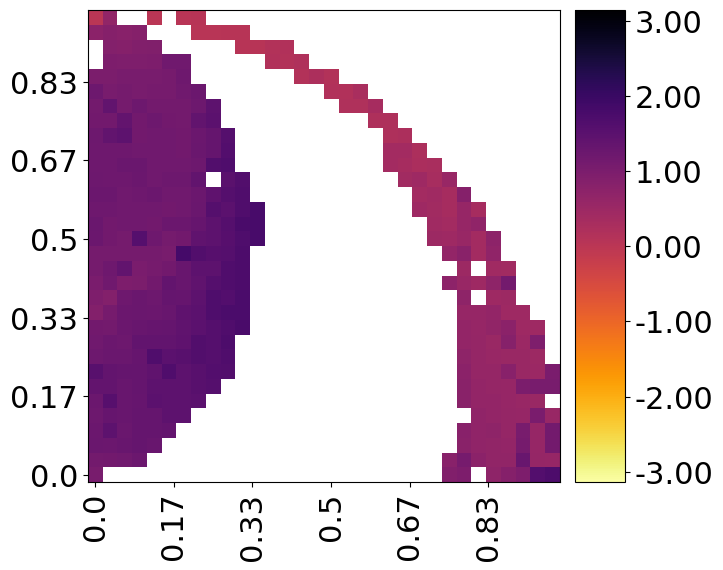

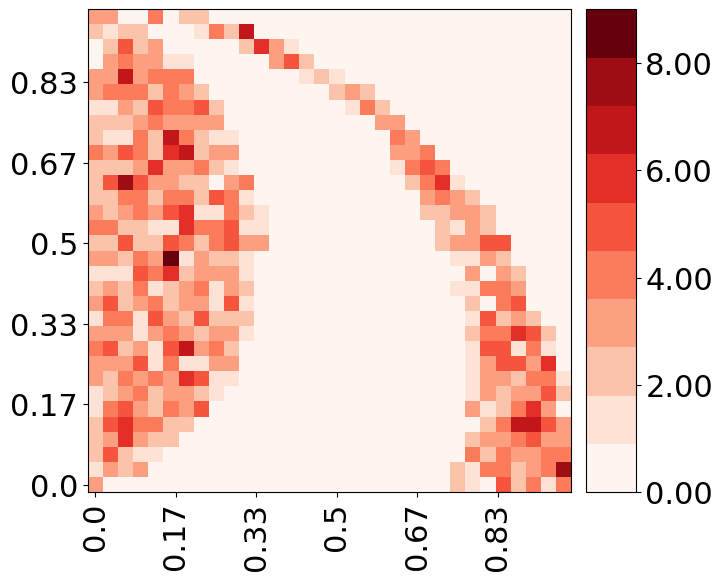

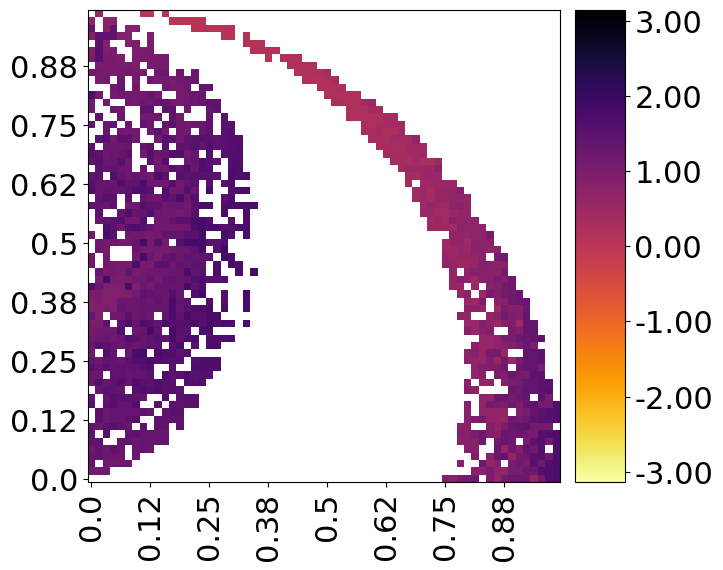

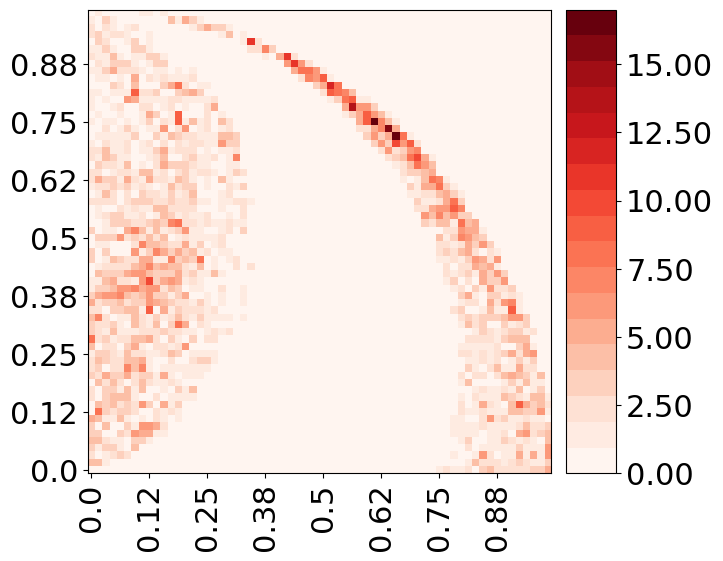

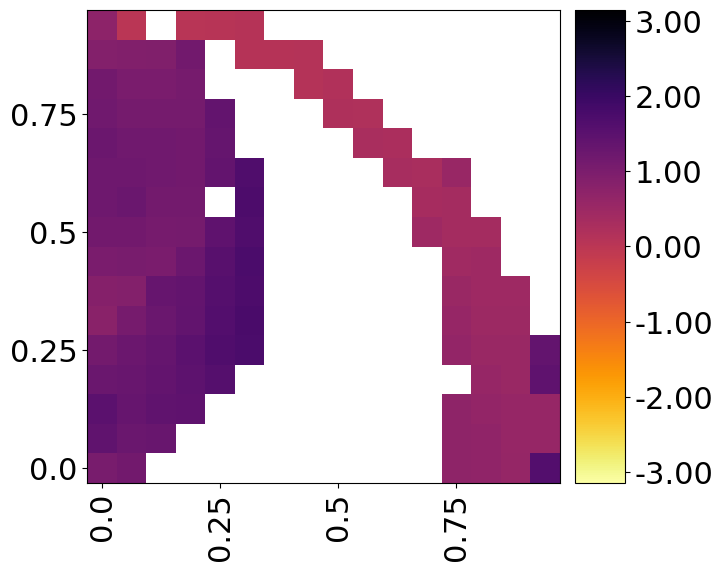

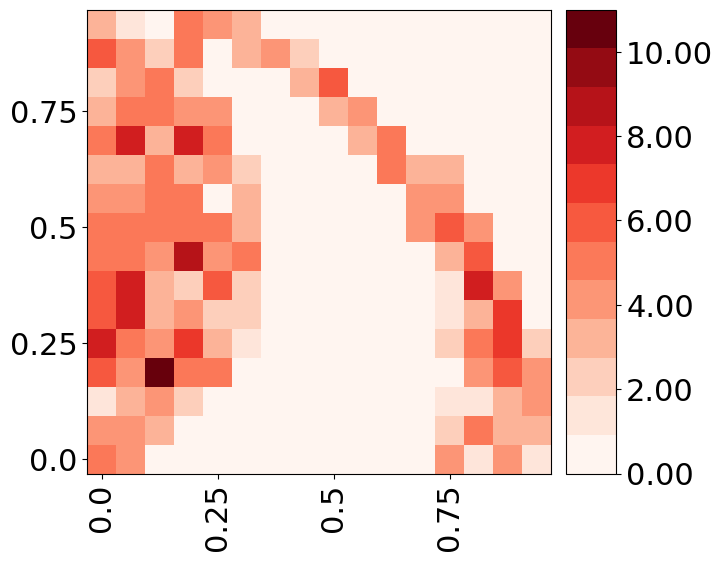

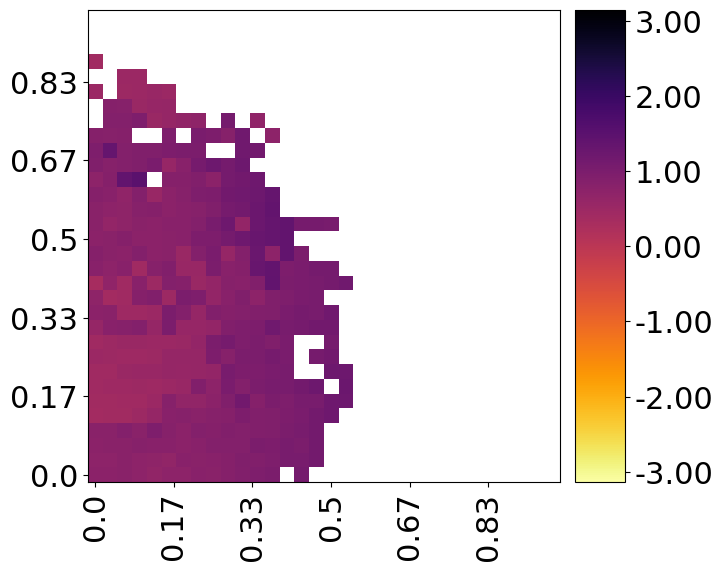

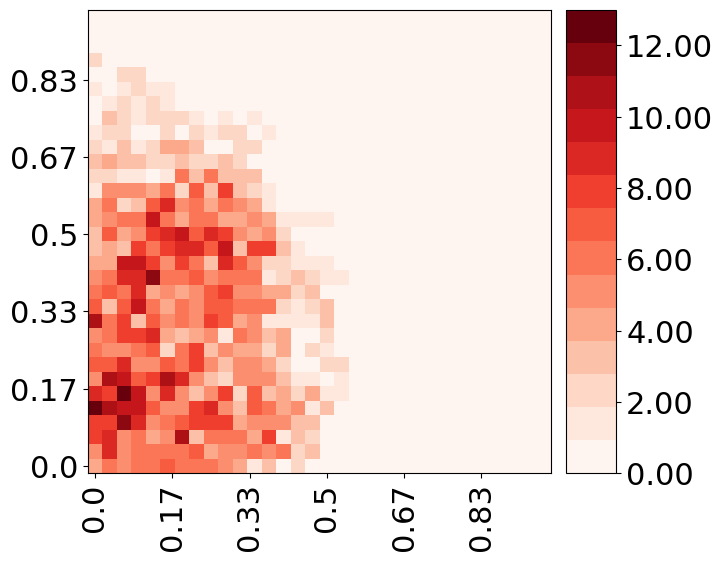

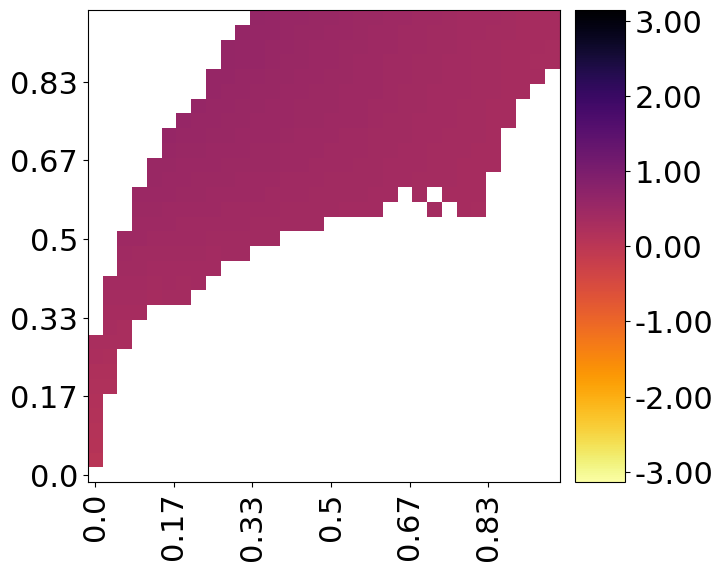

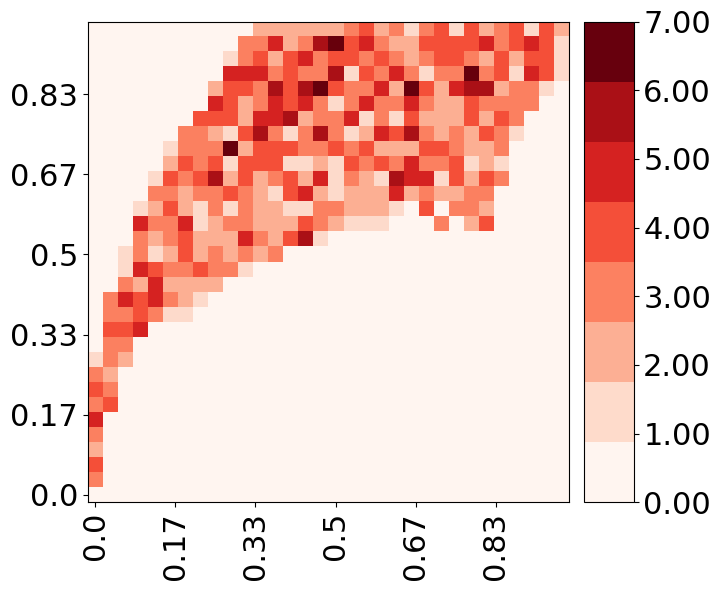

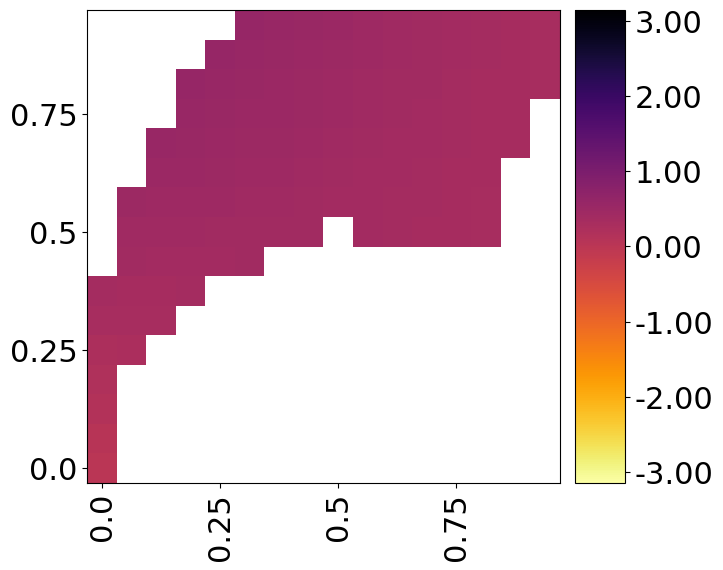

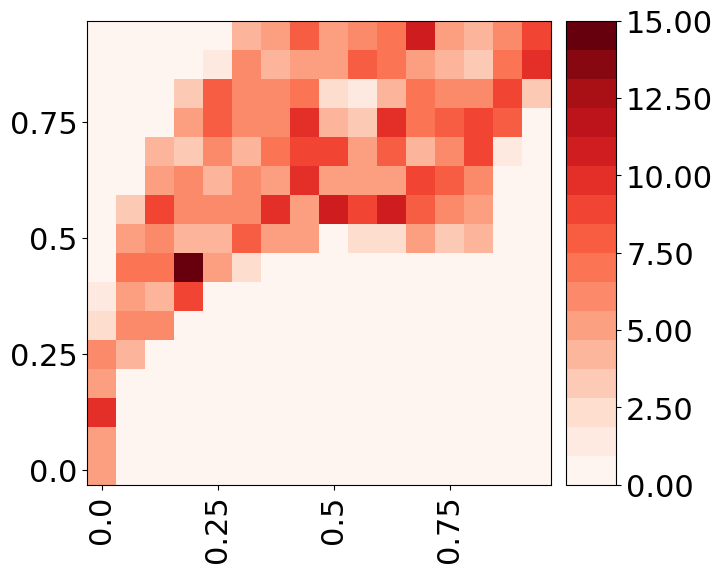

In [19]:
from utils.utils_12.exercise_custom_eval_fn import main
import math
"""
-------------------------------------------------------------------------
Edit this part to do the exercises
"""

# TODO: try to define a different objective function (score) and/or features (fit0, fit1)
def eval_fn(ind):
    """An example evaluation function. It takes an individual as input, and returns the pair ``(fitness, features)``, where ``fitness`` and ``features`` are sequences of scores."""
    normalization = sum((x for x in ind))
    k = 10.
    score = 1. - sum(( math.cos(k * ind[i]) * math.exp(-(ind[i]*ind[i])/2.) for i in range(len(ind)))) / float(len(ind))
    fit0 = sum((x * math.sin(abs(x) * 2. * math.pi) for x in ind)) / normalization
    fit1 = sum((x * math.cos(abs(x) * 2. * math.pi) for x in ind)) / normalization
    features = (fit0, fit1)
    return (score,), features

def eval_fn1(ind):
    score = abs(math.sin(sum(ind)) * math.exp(-sum(x**2 for x in ind)))
    fit0 = sum(x * math.sin(x) for x in ind)
    fit1 = sum(x * math.cos(x) for x in ind)
    return (score,), (fit0, fit1)




runs = {
    'run1': {'NO_BINS': 32, 'MAX_ITEMS_BIN': 1, 'BUDGET': 10000, 'BATCH_SIZE': 500, 'PROBLEM_DIM': 3, 'EVAL_FN':eval_fn },
    'run2': {'NO_BINS': 64, 'MAX_ITEMS_BIN': 5, 'BUDGET': 15000, 'BATCH_SIZE': 500, 'PROBLEM_DIM': 3, 'EVAL_FN':eval_fn },
    'run3': {'NO_BINS': 16, 'MAX_ITEMS_BIN': 1, 'BUDGET': 5000, 'BATCH_SIZE': 250, 'PROBLEM_DIM': 3, 'EVAL_FN':eval_fn },
    'run4': {'NO_BINS': 32, 'MAX_ITEMS_BIN': 1, 'BUDGET': 10000, 'BATCH_SIZE': 500, 'PROBLEM_DIM': 10, 'EVAL_FN':eval_fn},
    'run5': {'NO_BINS': 32, 'MAX_ITEMS_BIN': 1, 'BUDGET': 10000, 'BATCH_SIZE': 500, 'PROBLEM_DIM': 3, 'EVAL_FN': eval_fn1 },
    'run6': {'NO_BINS': 16, 'MAX_ITEMS_BIN': 1, 'BUDGET': 10000, 'BATCH_SIZE': 500, 'PROBLEM_DIM': 3, 'EVAL_FN': eval_fn1 },

    }

"""
-------------------------------------------------------------------------
"""

for run in runs:
    print(run, runs[run])
    NO_BINS = runs[run]['NO_BINS']
    MAX_ITEMS_BIN = runs[run]['MAX_ITEMS_BIN']
    BUDGET = runs[run]['BUDGET']
    BATCH_SIZE = runs[run]['BATCH_SIZE']
    PROBLEM_DIM = runs[run]['PROBLEM_DIM']
    EVAL = runs[run]['EVAL_FN']
    main(EVAL, NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

"""
-------------------------------------------------------------------------
"""


In [21]:
import pickle


for run in ['run1', 'run2', 'run3', 'run4', 'run5', 'run6']:
    print('-------------------------------------')
    print(f'risultati della {run}')
    with open(f"results/ex2/{run}/final.p", "rb") as f:
        data = pickle.load(f)

    grid = data['container']
    print('best individual:\t',grid.best)           # Migliore individuo
    print('best fitness:\t',grid.best.fitness)   # Fitness del miglior individuo
    print('best features:\t',grid.best.features)  # Feature descriptor del miglior individuo



-------------------------------------
risultati della run1
best individual:	 Individual([0.03777512364581248, 0.05210117796174074, 0.013444766998291668])
best fitness:	 (0.0713803207242063,)
best features:	 (0.2590877742126405, 0.9625066495789525)
-------------------------------------
risultati della run2
best individual:	 Individual([0.013435114375615176, 0.021356274789784524, 0.0020425683997167265])
best fitness:	 (0.010750828034025606,)
best features:	 (0.10903267804084792, 0.9934845970558384)
-------------------------------------
risultati della run3
best individual:	 Individual([0.005485449295817291, 0.01042945977725851, 0.011873621253140287])
best fitness:	 (0.0047059516651688504,)
best features:	 (0.06322682386720778, 0.9978886758675386)
-------------------------------------
risultati della run4
best individual:	 Individual([0.6818412520028518, 0.09368626134472735, 0.23594191794823816, 0.14717964243719994, 0.12235310156175527, 0.039269531390679124, 0.12218021275905633, 0.1545148

# Instructions and questions

Concisely note down your observations from the previous exercises (follow the bullet points) and think about the following questions. 

 - Do you think there is a trade-off between quality and diversity, or one aspect is more important than the other? If so, which one, and in which circumstances?

 Trade-off: Yes, there is a trade-off between quality and diversity.
Quality refers to finding the best possible solutions (lowest fitness).
Diversity ensures that solutions span a wide range of features.

Importance:
In optimization tasks where finding the best solution is paramount, quality is more important.
In exploratory tasks or problems with uncertain environments (e.g., robotics or game design), diversity is crucial to ensure robustness and adaptability.

Circumstances:
High-Quality Focus: When the solution space is well-defined, and the goal is clear (e.g., minimizing cost).
High-Diversity Focus: When multiple viable solutions are needed to handle uncertainty or variability (e.g., evolving diverse robot behaviors).

 
 - In which kind of applications do you think that MAP-Elites (and quality-diversity algorithms in general) could be useful? Why?

 Applications of MAP-Elites

Robotics:
Useful for generating diverse and adaptable robot behaviors to handle dynamic environments.
Example: Evolving walking patterns for a robot to adapt to different terrains.

Game Design:
Designing diverse levels, characters, or strategies to enhance player experience.
Example: Generating a variety of game levels that are both challenging and fun.

Neural Architecture Search (NAS):
Exploring diverse neural network architectures to find high-performing models.
Balancing quality (accuracy) with diversity (different architectures).


Why: MAP-Elites is valuable in these scenarios because it not only finds high-performing solutions but also maintains a diverse set of solutions, making it robust and adaptable to various challenges and uncertainties.